In [1]:
# 1. Instalace a import závislostí
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import warnings
from tqdm import tqdm

# Darts - Time Series Library
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mape
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)

# Foundation Models (optional)
try:
    from chronos import ChronosPipeline
    import torch
    CHRONOS_AVAILABLE = True
except ImportError:
    CHRONOS_AVAILABLE = False

try:
    from nixtla import NixtlaClient
    TIMEGPT_AVAILABLE = True
except ImportError:
    TIMEGPT_AVAILABLE = False

# Suppress warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("darts").setLevel(logging.WARNING)

print("Knihovny importovány.")
print(f"Chronos: {'Dostupný' if CHRONOS_AVAILABLE else 'Není nainstalován (pip install chronos-forecasting)'}")
print(f"TimeGPT: {'Dostupný' if TIMEGPT_AVAILABLE else 'Není nainstalován (pip install nixtla)'}")

Knihovny importovány.
Chronos: Dostupný
TimeGPT: Dostupný


In [2]:
# 1.1 Kontrola dostupnosti modelů
try:
    from darts.models import AutoARIMA
    print("AutoARIMA: Dostupný")
except ImportError:
    print("AutoARIMA: NENÍ dostupný")

try:
    from darts.models import Prophet
    print("Prophet: Dostupný")
except ImportError:
    print("Prophet: NENÍ dostupný (pip install prophet)")

AutoARIMA: Dostupný
Prophet: Dostupný


Dataset: ECB EUR/CZK Monthly
Celá řada: 1993-12-01 00:00:00 až 2025-12-01 00:00:00 (385 bodů)
Trénovací sada: 1993-12-01 00:00:00 až 2023-12-01 00:00:00 (361 bodů)
Testovací sada: 2024-01-01 00:00:00 až 2025-12-01 00:00:00 (24 bodů)
Sezónní perioda: 12


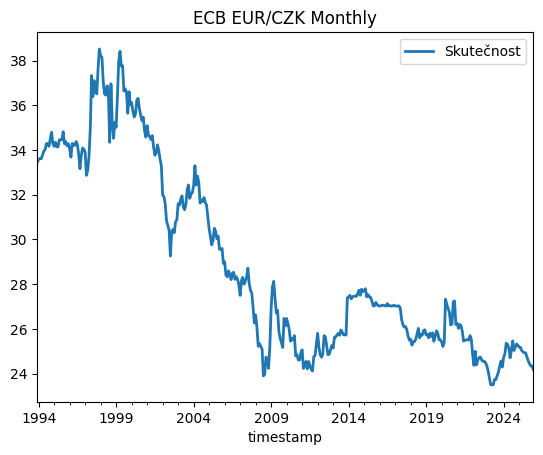

In [3]:
# 2. Načtení a předzpracování dat

# ============================================================================
# KONFIGURACE DATASETU - ZMĚŇTE TYTO HODNOTY PRO JINÉ DATASETY
# ============================================================================
DATASET_CONFIG = {
    # Cesta k datasetu (relativní k tomuto notebooku)
    'file_path': '../datasets/ecb_eurczk_monthly.csv',
    
    # Názvy sloupců
    'time_column': 'timestamp',      # Název sloupce s datem
    'target_column': 'eur_czk',      # Název sloupce s cílovou proměnnou
    
    # Frekvence časové řady a rozdělení na test
    'frequency': 'MS',               # 'MS'=měsíční, 'QS'=kvartální, 'YS'=roční, 'H'=hodinová, 'D'=denní
    'test_periods': 24,              # Počet období pro testování
    'seasonal_period': 12,           # Sezónní perioda (12=měsíční, 4=kvartální, 1=roční, 24=hodinová, 7=denní)
    
    # Název datasetu pro grafy
    'name': 'ECB EUR/CZK Monthly'
}

# ============================================================================
# DOSTUPNÉ KONFIGURACE DATASETŮ (odkomentujte pro použití)
# ============================================================================
# DATASET_CONFIG = {
#     'file_path': '../datasets/wb_usa_real_gdp_yearly.csv',
#     'time_column': 'timestamp', 'target_column': 'real_gdp',
#     'frequency': 'YS', 'test_periods': 10, 'seasonal_period': 1,
#     'name': 'World Bank USA Real GDP Yearly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/fred_gpdic1_investments_quarterly.csv',
#     'time_column': 'timestamp', 'target_column': 'gpdic1',
#     'frequency': 'QS', 'test_periods': 8, 'seasonal_period': 4,
#     'name': 'FRED GPDIC1 Investments Quarterly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/m5_walmart_hobbies_daily.csv',
#     'time_column': 'timestamp', 'target_column': 'sales',
#     'frequency': 'D', 'test_periods': 28, 'seasonal_period': 7,
#     'name': 'M5 Walmart Hobbies Daily'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/kaggle_btcusd_hourly.csv',
#     'time_column': 'timestamp', 'target_column': 'close',
#     'frequency': 'H', 'test_periods': 168, 'seasonal_period': 24,
#     'name': 'Kaggle BTC/USD Hourly'
# }

# ============================================================================
# NAČTENÍ A PŘEDZPRACOVÁNÍ DAT (není třeba měnit)
# ============================================================================
df = pd.read_csv(DATASET_CONFIG['file_path'])
df[DATASET_CONFIG['time_column']] = pd.to_datetime(df[DATASET_CONFIG['time_column']])
series = TimeSeries.from_dataframe(df, DATASET_CONFIG['time_column'], DATASET_CONFIG['target_column'])

# Převod na float32 pro kompatibilitu s MPS/DL
series = series.astype(np.float32)

# Rozdělení Train/Test podle frekvence
freq = DATASET_CONFIG['frequency']
test_periods = DATASET_CONFIG['test_periods']

if freq == 'MS':
    offset = pd.DateOffset(months=test_periods)
elif freq == 'QS':
    offset = pd.DateOffset(months=test_periods * 3)
elif freq == 'YS':
    offset = pd.DateOffset(years=test_periods)
elif freq == 'D':
    offset = pd.DateOffset(days=test_periods)
elif freq == 'H':
    offset = pd.DateOffset(hours=test_periods)
else:
    offset = pd.DateOffset(days=test_periods)

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# Scaler pro DL modely
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Celá řada: {series.start_time()} až {series.end_time()} ({len(series)} bodů)")
print(f"Trénovací sada: {train.start_time()} až {train.end_time()} ({len(train)} bodů)")
print(f"Testovací sada: {test.start_time()} až {test.end_time()} ({len(test)} bodů)")
print(f"Sezónní perioda: {DATASET_CONFIG['seasonal_period']}")

series.plot(label='Skutečnost')
plt.title(DATASET_CONFIG['name'])
plt.show()

In [4]:
# 3. Definice evaluačních metrik a logování

results = []

def log_result(model_name, rmse_val, mape_val, tuning_time, best_config_time, params=None, n_combinations=1):
    """
    Zaloguje výsledky modelu s kompletními časovými informacemi.
    
    Args:
        tuning_time: Celkový čas ladění hyperparametrů (všechny kombinace + CV)
        best_config_time: Čas pouze pro nejlepší konfiguraci (trénování + CV)
        n_combinations: Počet vyhodnocených kombinací parametrů
    """
    results.append({
        'Model': model_name,
        'RMSE': rmse_val,
        'MAPE': mape_val,
        'Tuning Time (s)': tuning_time,
        'Best Config Time (s)': best_config_time,
        'Combinations': n_combinations,
        'Params': params
    })
    print(f"Zalogováno: {model_name} | RMSE: {rmse_val:.4f} | MAPE: {mape_val:.2f}% | "
          f"Tuning: {tuning_time:.2f}s ({n_combinations} kombinací) | Nejlepší: {best_config_time:.2f}s")

def get_results_df():
    return pd.DataFrame(results).sort_values(by='RMSE')

In [5]:
# 4. Strategie ladění hyperparametrů (Grid/Random Search) a křížová validace

# GLOBÁLNÍ SEED PRO REPRODUKOVATELNOST
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def grid_search_all(param_grid):
    """Generuje VŠECHNY kombinace z parametrového gridu (full grid search)."""
    from itertools import product
    
    if not param_grid:
        return [{}]
    
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    
    combinations = []
    for combo in product(*values):
        params = dict(zip(keys, combo))
        combinations.append(params)
    
    return combinations

def random_grid_search(param_grid, n_iter=5, seed=RANDOM_SEED):
    """Generuje náhodné kombinace parametrů s fixním seedem pro reprodukovatelnost."""
    rng = random.Random(seed)
    keys = list(param_grid.keys())
    
    if not keys:
        return [{}]

    combinations = []
    for _ in range(n_iter):
        params = {}
        for key in keys:
            params[key] = rng.choice(param_grid[key])
        combinations.append(params)
    
    # Odstranění duplicit
    seen = set()
    unique_combinations = []
    for d in combinations:
        key = frozenset((k, str(v)) for k, v in d.items())
        if key not in seen:
            seen.add(key)
            unique_combinations.append(d)
    
    return unique_combinations

def evaluate_model(model_cls, params, series_train, series_val, is_dl=False, forecast_horizon=12, stride=1, scaler=None, original_series=None):
    """Evaluuje model pomocí rolling window cross-validace (historical_forecasts)."""
    start_time = time.time()
    
    try:
        model = model_cls(**params)
        
        if is_dl:
            model.fit(series_train, verbose=False)
            backtest_series = model.historical_forecasts(
                series=series_train, start=0.7, forecast_horizon=forecast_horizon,
                stride=stride, retrain=False, verbose=False, last_points_only=True
            )
        else:
            backtest_series = model.historical_forecasts(
                series=series_train, start=0.7, forecast_horizon=forecast_horizon,
                stride=stride, retrain=True, verbose=False, last_points_only=True
            )
            
        if scaler:
            backtest_series = scaler.inverse_transform(backtest_series)
            actual_series = original_series if original_series else scaler.inverse_transform(series_train)
        else:
            actual_series = series_train

        rmse_score = rmse(actual_series, backtest_series)
        mape_score = mape(actual_series, backtest_series)
        
        return rmse_score, mape_score, time.time() - start_time
        
    except Exception as e:
        model_name = getattr(model_cls, '__name__', str(model_cls))
        print(f"Chyba při evaluaci {model_name} s parametry {params}: {e}")
        return float('inf'), float('inf'), 0

def run_tuning_and_eval(model_name, model_cls, param_grid, train_series, is_dl=False, 
                        n_iter=5, scaler=None, original_series=None, use_full_grid=False):
    """Spustí ladění hyperparametrů a měří CELKOVÝ čas tuningu."""
    print(f"--- Ladění {model_name} ---")
    
    tuning_start_time = time.time()
    
    if not param_grid:
        best_params = {}
        rmse_val, mape_val, config_time = evaluate_model(model_cls, {}, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        tuning_total_time = time.time() - tuning_start_time
        if rmse_val != float('inf'):
            log_result(model_name, rmse_val, mape_val, tuning_total_time, config_time, best_params, n_combinations=1)
        return best_params
    
    if use_full_grid:
        combinations = grid_search_all(param_grid)
        print(f"Full grid search: {len(combinations)} kombinací")
    else:
        combinations = random_grid_search(param_grid, n_iter=n_iter, seed=RANDOM_SEED)
        print(f"Random search (seed={RANDOM_SEED}): {len(combinations)} kombinací")
    
    best_rmse = float('inf')
    best_params = None
    best_config_time = 0
    
    for params in tqdm(combinations, desc=f"Ladění {model_name}"):
        rmse_val, mape_val, config_time = evaluate_model(model_cls, params, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_params = params
            best_mape = mape_val
            best_config_time = config_time
    
    tuning_total_time = time.time() - tuning_start_time
            
    if best_params is not None and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_mape, tuning_total_time, best_config_time, best_params, n_combinations=len(combinations))
    else:
        print(f"Žádný úspěšný běh pro {model_name}")
    return best_params

print(f"Random seed nastaven na: {RANDOM_SEED} (pro reprodukovatelnost)")

Random seed nastaven na: 42 (pro reprodukovatelnost)


In [6]:
# 5. Trénování a evaluace statistických modelů (Darts)
from darts.utils.utils import ModelMode

SEASONAL_PERIOD = DATASET_CONFIG['seasonal_period']
print(f"Sezónní perioda: {SEASONAL_PERIOD}")

# Holt-Winters (ExponentialSmoothing)
hw_grid = {
    'seasonal_periods': [SEASONAL_PERIOD],
    'trend': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'seasonal': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'damped': [True, False]
}
run_tuning_and_eval("Holt-Winters", ExponentialSmoothing, hw_grid, train, is_dl=False, use_full_grid=True)

# AutoARIMA
try:
    AutoARIMA()
    arima_available = True
except:
    print("AutoARIMA není dostupný. Přeskakuji.")
    arima_available = False

if arima_available:
    arima_grid = {
        'season_length': [SEASONAL_PERIOD],
        'seasonal': [True] if SEASONAL_PERIOD > 1 else [False],
        'max_p': [5], 'max_q': [5],
        'max_P': [2], 'max_Q': [2], 'max_D': [1],
    }
    run_tuning_and_eval("AutoARIMA", AutoARIMA, arima_grid, train, is_dl=False, use_full_grid=True)

# Prophet
try:
    Prophet()
    prophet_available = True
except:
    print("Prophet není dostupný. Přeskakuji.")
    prophet_available = False

if prophet_available:
    prophet_grid = {
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    }
    run_tuning_and_eval("Prophet", Prophet, prophet_grid, train, is_dl=False, use_full_grid=True)

Sezónní perioda: 12
--- Ladění Holt-Winters ---
Full grid search: 18 kombinací


Ladění Holt-Winters:  67%|██████▋   | 12/18 [01:15<00:36,  6.14s/it]

Chyba při evaluaci ExponentialSmoothing s parametry {'seasonal_periods': 12, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.ADDITIVE: 'additive'>, 'damped': True}: Can only dampen the trend component


Ladění Holt-Winters:  78%|███████▊  | 14/18 [01:16<00:13,  3.48s/it]

Chyba při evaluaci ExponentialSmoothing s parametry {'seasonal_periods': 12, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'damped': True}: Can only dampen the trend component


Ladění Holt-Winters: 100%|██████████| 18/18 [01:18<00:00,  4.33s/it]


Chyba při evaluaci ExponentialSmoothing s parametry {'seasonal_periods': 12, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.NONE: None>, 'damped': True}: Can only dampen the trend component
Zalogováno: Holt-Winters | RMSE: 0.8055 | MAPE: 2.54% | Tuning: 78.03s (18 kombinací) | Nejlepší: 1.88s
--- Ladění AutoARIMA ---
Full grid search: 1 kombinací


Ladění AutoARIMA: 100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


Zalogováno: AutoARIMA | RMSE: 0.8981 | MAPE: 2.87% | Tuning: 13.59s (1 kombinací) | Nejlepší: 13.59s
--- Ladění Prophet ---
Full grid search: 8 kombinací


Ladění Prophet:   0%|          | 0/8 [00:00<?, ?it/s]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to overr

Zalogováno: Prophet | RMSE: 1.2964 | MAPE: 3.86% | Tuning: 62.66s (8 kombinací) | Nejlepší: 5.26s


In [7]:
# 6. Trénování a evaluace Deep Learning modelů (Darts)
# Vyžadují škálovaná data, používáme RANDOM SEARCH s fixním seedem

base_chunk = SEASONAL_PERIOD
common_dl_params = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],
    'random_state': [RANDOM_SEED]
}

print(f"DL input_chunk_length: {common_dl_params['input_chunk_length']}")
print(f"DL output_chunk_length: {common_dl_params['output_chunk_length']}")

# TiDE
tide_grid = {**common_dl_params, 'hidden_size': [64, 128], 'dropout': [0.1, 0.2],
             'num_encoder_layers': [1, 2], 'num_decoder_layers': [1, 2]}
run_tuning_and_eval("TiDE", TiDEModel, tide_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train, use_full_grid=False)

# N-BEATS
nbeats_grid = {**common_dl_params, 'num_stacks': [10, 20], 'num_blocks': [1, 2], 'layer_widths': [128, 256]}
run_tuning_and_eval("N-BEATS", NBEATSModel, nbeats_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train, use_full_grid=False)

# TFT (Temporal Fusion Transformer)
tft_grid = {**common_dl_params, 'hidden_size': [16, 32], 'lstm_layers': [1],
            'num_attention_heads': [4], 'dropout': [0.1], 'add_relative_index': [True]}
run_tuning_and_eval("TFT", TFTModel, tft_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train, use_full_grid=False)

DL input_chunk_length: [12, 24]
DL output_chunk_length: [1, 6, 12]
--- Ladění TiDE ---
Random search (seed=42): 10 kombinací


Ladění TiDE:   0%|          | 0/10 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Ladění TiDE:  10%|█         | 1/10 [00:01<00:13,  1.52s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Ladění TiDE:  20%|██        | 2/10 [00:02<00:07,  1.05it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HP

Zalogováno: TiDE | RMSE: 0.7906 | MAPE: 2.64% | Tuning: 8.88s (10 kombinací) | Nejlepší: 0.88s
--- Ladění N-BEATS ---
Random search (seed=42): 9 kombinací


Ladění N-BEATS:   0%|          | 0/9 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Ladění N-BEATS:  11%|█         | 1/9 [00:03<00:29,  3.71s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Ladění N-BEATS:  22%|██▏       | 2/9 [00:07<00:25,  3.64s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using

Zalogováno: N-BEATS | RMSE: 0.8535 | MAPE: 2.80% | Tuning: 47.60s (9 kombinací) | Nejlepší: 3.67s
--- Ladění TFT ---
Random search (seed=42): 8 kombinací


Ladění TFT:   0%|          | 0/8 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Ladění TFT:  12%|█▎        | 1/8 [00:05<00:35,  5.06s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Ladění TFT:  25%|██▌       | 2/8 [00:07<00:20,  3.49s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lad

Zalogováno: TFT | RMSE: 2.3403 | MAPE: 6.77% | Tuning: 29.10s (8 kombinací) | Nejlepší: 5.06s


{'input_chunk_length': 12,
 'output_chunk_length': 1,
 'n_epochs': 20,
 'random_state': 42,
 'hidden_size': 16,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [8]:
# 7. Foundation modely (Chronos, TimeGPT)

# ============================================================================
# KONFIGURACE API KLÍČŮ
# ============================================================================
API_KEYS = {
    'NIXTLA_API_KEY': None,  # Získejte na https://dashboard.nixtla.io/
}

# ============================================================================
# CHRONOS (Amazon) - Lokální, nepotřebuje API klíč
# ============================================================================
if CHRONOS_AVAILABLE:
    try:
        start_time = time.time()
        
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu",
            torch_dtype=torch.float32
        )
        
        context = torch.tensor(train.values().flatten())
        forecast = pipeline.predict(context, prediction_length=len(test), num_samples=20)
        pred_values = forecast.median(dim=1).values.numpy()
        
        pred_chronos = TimeSeries.from_times_and_values(times=test.time_index, values=pred_values)
        
        chronos_time = time.time() - start_time
        log_result("Chronos", rmse(test, pred_chronos), mape(test, pred_chronos), 
                   chronos_time, chronos_time, {'model': 'chronos-t5-small'}, n_combinations=1)
        
    except Exception as e:
        print(f"Chronos chyba: {e}")

# ============================================================================
# TIMEGPT (Nixtla) - Vyžaduje API klíč
# ============================================================================
if TIMEGPT_AVAILABLE and API_KEYS['NIXTLA_API_KEY']:
    try:
        start_time = time.time()
        
        nixtla_client = NixtlaClient(api_key=API_KEYS['NIXTLA_API_KEY'])
        train_df = train.pd_dataframe().reset_index()
        train_df.columns = ['ds', 'y']
        
        forecast_df = nixtla_client.forecast(df=train_df, h=len(test), model='timegpt-1', freq=DATASET_CONFIG['frequency'])
        pred_timegpt = TimeSeries.from_times_and_values(times=test.time_index, values=forecast_df['TimeGPT'].values)
        
        timegpt_time = time.time() - start_time
        log_result("TimeGPT", rmse(test, pred_timegpt), mape(test, pred_timegpt),
                   timegpt_time, timegpt_time, {'model': 'timegpt-1'}, n_combinations=1)
        
    except Exception as e:
        print(f"TimeGPT chyba: {e}")
elif TIMEGPT_AVAILABLE and not API_KEYS['NIXTLA_API_KEY']:
    print("TimeGPT: API klíč není nastaven. Nastavte API_KEYS['NIXTLA_API_KEY'].")

print("\n--- Shrnutí Foundation modelů ---")
print(f"Chronos: {'Dostupný' if CHRONOS_AVAILABLE else 'Není nainstalován'}")
print(f"TimeGPT: {'API klíč nastaven' if (TIMEGPT_AVAILABLE and API_KEYS['NIXTLA_API_KEY']) else 'Potřebuje API klíč' if TIMEGPT_AVAILABLE else 'Není nainstalován'}")

`torch_dtype` is deprecated! Use `dtype` instead!
ERROR:darts.timeseries:ValueError: The time index and values must have the same length.


Chronos chyba: The time index and values must have the same length.
TimeGPT: API klíč není nastaven. Nastavte API_KEYS['NIXTLA_API_KEY'].

--- Shrnutí Foundation modelů ---
Chronos: Dostupný
TimeGPT: Potřebuje API klíč


          Model      RMSE      MAPE  Tuning Time (s)  Best Config Time (s)  \
3          TiDE  0.790585  2.636333         8.878097              0.883929   
0  Holt-Winters  0.805530  2.544134        78.029141              1.884964   
4       N-BEATS  0.853470  2.803128        47.597932              3.673344   
1     AutoARIMA  0.898150  2.869939        13.594411             13.593288   
2       Prophet  1.296377  3.855752        62.661042              5.258443   
5           TFT  2.340295  6.765427        29.096946              5.064705   

   Combinations                                             Params  
3            10  {'input_chunk_length': 24, 'output_chunk_lengt...  
0            18  {'seasonal_periods': 12, 'trend': ModelMode.MU...  
4             9  {'input_chunk_length': 12, 'output_chunk_lengt...  
1             1  {'season_length': 12, 'seasonal': True, 'max_p...  
2             8  {'seasonality_mode': 'multiplicative', 'change...  
5             8  {'input_chunk_length':

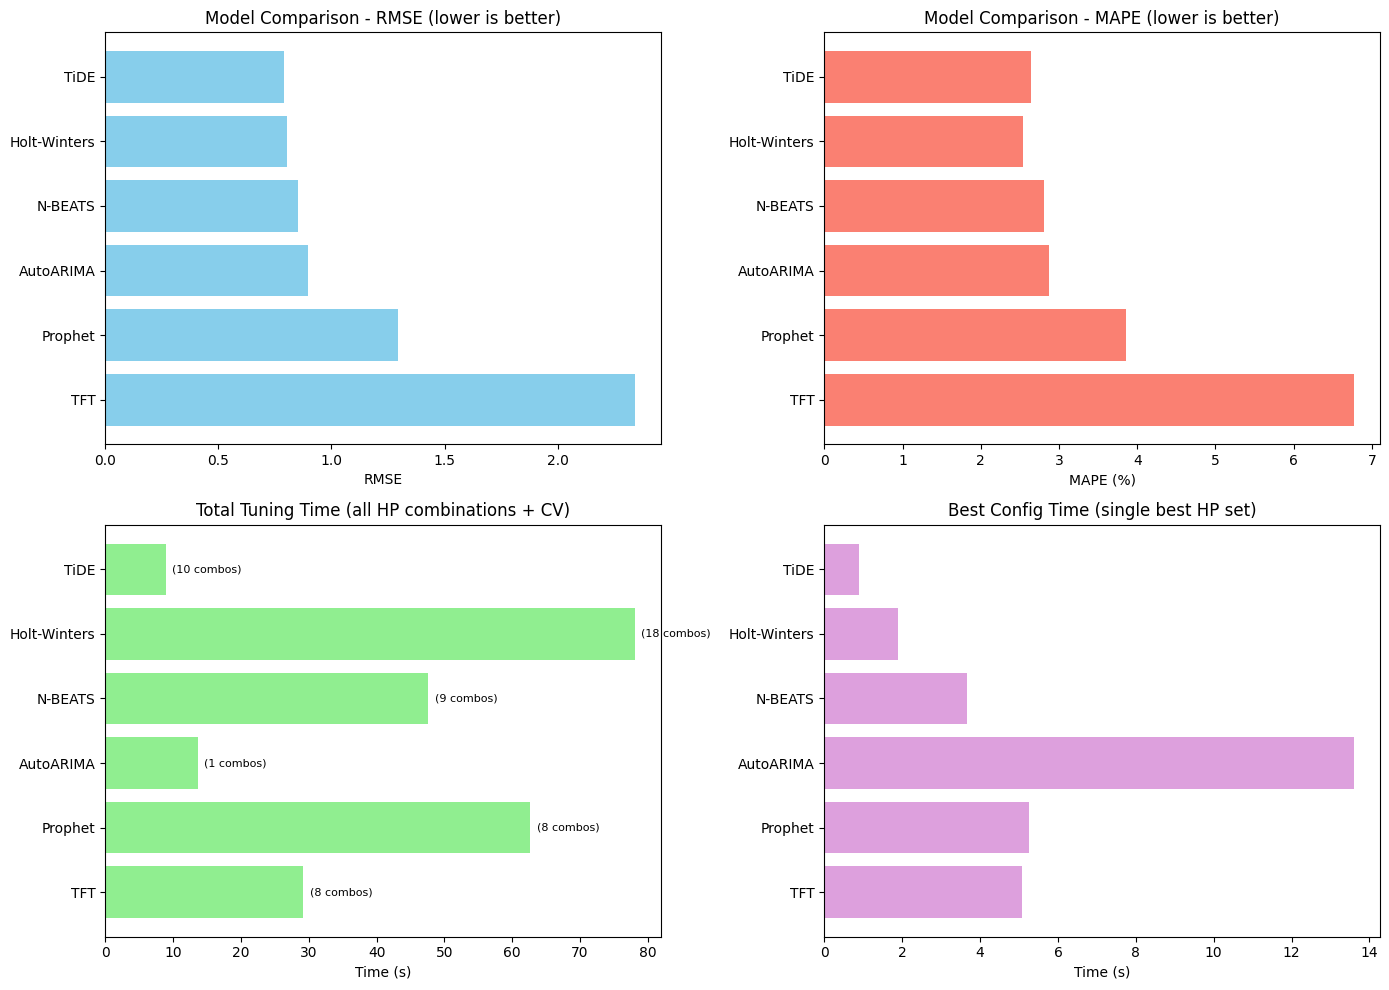


=== Summary ===
Best RMSE: TiDE (0.7906)
Best MAPE: Holt-Winters (2.54%)
Fastest Tuning: TiDE (8.88s)
Fastest Config: TiDE (0.88s)


In [9]:
# 8. Compare Results

results_df = get_results_df()
print(results_df)

# Plot comparison with multiple metrics (RMSE, MAPE, Tuning Time, Best Config Time)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE comparison
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Model Comparison - RMSE (lower is better)')
axes[0, 0].invert_yaxis()

# MAPE comparison
axes[0, 1].barh(results_df['Model'], results_df['MAPE'], color='salmon')
axes[0, 1].set_xlabel('MAPE (%)')
axes[0, 1].set_title('Model Comparison - MAPE (lower is better)')
axes[0, 1].invert_yaxis()

# Total Tuning Time comparison (includes all HP combinations + CV)
axes[1, 0].barh(results_df['Model'], results_df['Tuning Time (s)'], color='lightgreen')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_title('Total Tuning Time (all HP combinations + CV)')
axes[1, 0].invert_yaxis()
# Add number of combinations as annotation
for i, (model, combos) in enumerate(zip(results_df['Model'], results_df['Combinations'])):
    axes[1, 0].annotate(f'({combos} combos)', xy=(results_df['Tuning Time (s)'].iloc[i], i), 
                        xytext=(5, 0), textcoords='offset points', va='center', fontsize=8)

# Best Config Time comparison (single best configuration)
axes[1, 1].barh(results_df['Model'], results_df['Best Config Time (s)'], color='plum')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_title('Best Config Time (single best HP set)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Summary table
print("\n=== Summary ===")
print(f"Best RMSE: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['RMSE']:.4f})")
print(f"Best MAPE: {results_df.sort_values('MAPE').iloc[0]['Model']} ({results_df.sort_values('MAPE').iloc[0]['MAPE']:.2f}%)")
print(f"Fastest Tuning: {results_df.sort_values('Tuning Time (s)').iloc[0]['Model']} ({results_df.sort_values('Tuning Time (s)').iloc[0]['Tuning Time (s)']:.2f}s)")
print(f"Fastest Config: {results_df.sort_values('Best Config Time (s)').iloc[0]['Model']} ({results_df.sort_values('Best Config Time (s)').iloc[0]['Best Config Time (s)']:.2f}s)")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 22.9 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 150    | train
--------------------------------------------------------------
64.9 K    Trainable params
0         Non-trainable params
64.9 K    Total params
0.260     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval 

Best RMSE Model: TiDE
  - Params: {'input_chunk_length': 24, 'output_chunk_length': 6, 'n_epochs': 20, 'random_state': 42, 'hidden_size': 128, 'dropout': 0.1, 'num_encoder_layers': 1, 'num_decoder_layers': 1}
  - RMSE: 0.7906, MAPE: 2.64%
  - Tuning time: 8.88s (10 combinations)

Fastest Tuning Model: TiDE
  - Params: {'input_chunk_length': 24, 'output_chunk_length': 6, 'n_epochs': 20, 'random_state': 42, 'hidden_size': 128, 'dropout': 0.1, 'num_encoder_layers': 1, 'num_decoder_layers': 1}
  - RMSE: 0.7906, MAPE: 2.64%
  - Tuning time: 8.88s (10 combinations)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

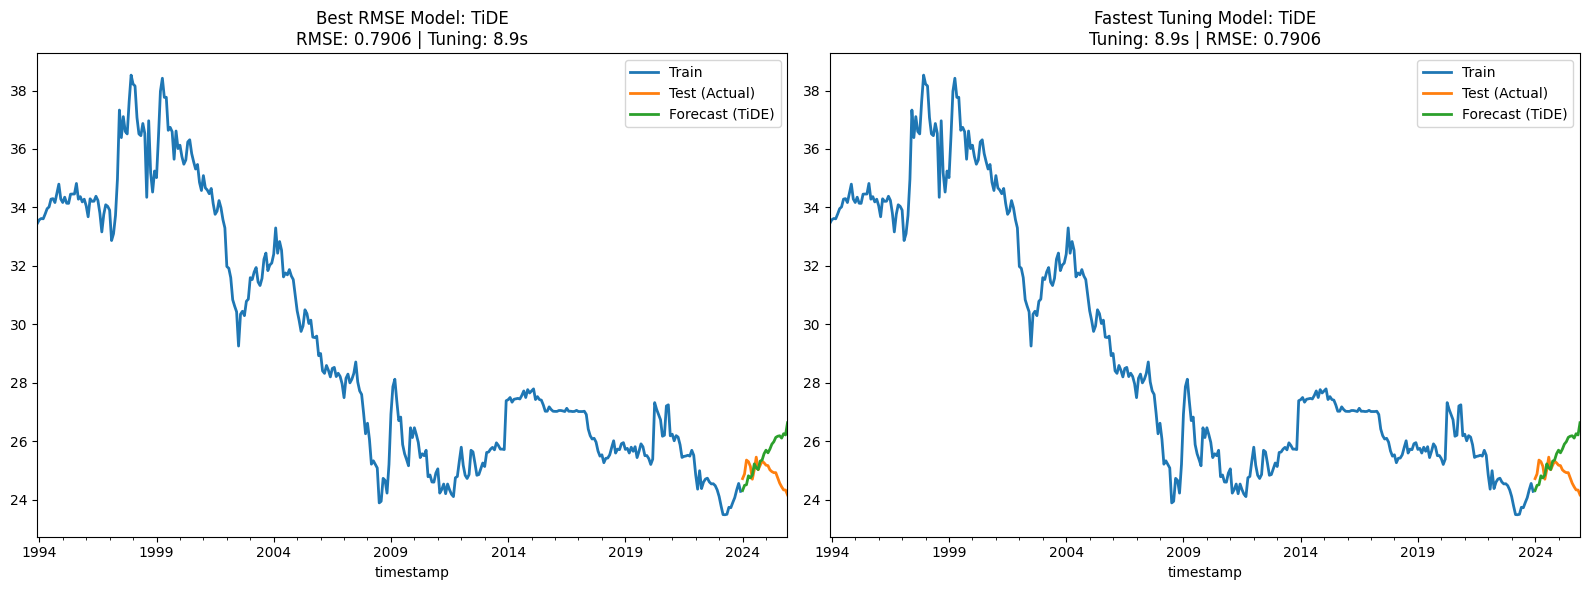

In [10]:
# 9. Final Prediction with Best Model (RMSE) and Fastest Tuning Model

def train_and_predict(model_name, params, is_dl):
    """Helper function to train model and get predictions."""
    model_map = {
        "Holt-Winters": ExponentialSmoothing,
        "AutoARIMA": AutoARIMA,
        "Prophet": Prophet,
        "TiDE": TiDEModel,
        "N-BEATS": NBEATSModel,
        "TFT": TFTModel
    }
    
    if model_name not in model_map:
        return None
        
    model_cls = model_map[model_name]
    model = model_cls(**params)
    
    if is_dl:
        model.fit(train_scaled)
        pred_scaled = model.predict(len(test))
        pred = scaler.inverse_transform(pred_scaled)
    else:
        model.fit(train)
        pred = model.predict(len(test))
    
    return pred

if not results_df.empty:
    # Best model by RMSE
    best_rmse_row = results_df.iloc[0]
    best_rmse_model = best_rmse_row['Model']
    best_rmse_params = best_rmse_row['Params']
    is_dl_rmse = best_rmse_model in ["TiDE", "N-BEATS", "TFT"]
    
    # Fastest model by TOTAL TUNING TIME (fair comparison including all HP search)
    fastest_df = results_df.sort_values(by='Tuning Time (s)')
    fastest_row = fastest_df.iloc[0]
    fastest_model = fastest_row['Model']
    fastest_params = fastest_row['Params']
    is_dl_fastest = fastest_model in ["TiDE", "N-BEATS", "TFT"]
    
    print(f"Best RMSE Model: {best_rmse_model}")
    print(f"  - Params: {best_rmse_params}")
    print(f"  - RMSE: {best_rmse_row['RMSE']:.4f}, MAPE: {best_rmse_row['MAPE']:.2f}%")
    print(f"  - Tuning time: {best_rmse_row['Tuning Time (s)']:.2f}s ({best_rmse_row['Combinations']} combinations)")
    print()
    print(f"Fastest Tuning Model: {fastest_model}")
    print(f"  - Params: {fastest_params}")
    print(f"  - RMSE: {fastest_row['RMSE']:.4f}, MAPE: {fastest_row['MAPE']:.2f}%")
    print(f"  - Tuning time: {fastest_row['Tuning Time (s)']:.2f}s ({fastest_row['Combinations']} combinations)")
    
    # Create predictions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Best RMSE Model
    pred_rmse = train_and_predict(best_rmse_model, best_rmse_params, is_dl_rmse)
    if pred_rmse is not None:
        train.plot(ax=axes[0], label='Train')
        test.plot(ax=axes[0], label='Test (Actual)')
        pred_rmse.plot(ax=axes[0], label=f'Forecast ({best_rmse_model})')
        axes[0].set_title(f'Best RMSE Model: {best_rmse_model}\nRMSE: {best_rmse_row["RMSE"]:.4f} | Tuning: {best_rmse_row["Tuning Time (s)"]:.1f}s')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, f'Model {best_rmse_model} not available', ha='center', va='center')
        axes[0].set_title('Best RMSE Model - Not Available')
    
    # Plot 2: Fastest Tuning Model
    if fastest_model == best_rmse_model:
        pred_fast = pred_rmse
    else:
        pred_fast = train_and_predict(fastest_model, fastest_params, is_dl_fastest)
    
    if pred_fast is not None:
        train.plot(ax=axes[1], label='Train')
        test.plot(ax=axes[1], label='Test (Actual)')
        pred_fast.plot(ax=axes[1], label=f'Forecast ({fastest_model})')
        axes[1].set_title(f'Fastest Tuning Model: {fastest_model}\nTuning: {fastest_row["Tuning Time (s)"]:.1f}s | RMSE: {fastest_row["RMSE"]:.4f}')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, f'Model {fastest_model} not available', ha='center', va='center')
        axes[1].set_title('Fastest Model - Not Available')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to display.")